<a href="https://colab.research.google.com/github/udupa-varun/pyimagesearch_uni/blob/main/deep_learning/106/keras_learning_rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/keras-learning-rates/keras-learning-rates.zip
!unzip -qq keras-learning-rates.zip
%cd keras-learning-rates

--2023-02-27 10:04:04--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/keras-learning-rates/keras-learning-rates.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.152.201, 52.92.132.242, 52.92.251.162, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.152.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293805 (287K) [binary/octet-stream]
Saving to: ‘keras-learning-rates.zip’

keras-learning-rate 100%[===================>] 286.92K   855KB/s    in 0.3s    

2023-02-27 10:04:05 (855 KB/s) - ‘keras-learning-rates.zip’ saved [293805/293805]

/content/keras-learning-rates


In [2]:
import argparse

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

from pyimagesearch.resnet import ResNet

In [3]:
class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
        # compute set of learning rates for each epoch
        lrs = [self(i) for i in epochs]

        # plot the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")

### Step-based Learning Rate schedules

In [4]:
class StepDecay(LearningRateDecay):
    def __init__(self, init_alpha=0.1, factor=0.25, drop_every=10):
        # store base learning rate, drop factor, drop period
        self.init_alpha = init_alpha
        self.factor = factor
        self.drop_every = drop_every
    
    def __call__(self, epoch):
        # compute learning rate for current epoch
        exp = np.floor((1 + epoch) / self.drop_every)
        alpha = self.init_alpha * (self.factor ** exp)

        return float(alpha)

### Linear and Polynomial Learning Rate schedules

In [5]:
class PolynomialDecay(LearningRateDecay):
    def __init__(self, max_epochs=100, init_alpha=0.01, power=1.0):
        # store params
        self.max_epochs = max_epochs
        self.init_alpha = init_alpha
        self.power = power

    def __call__(self, epoch):
        # compute new learning rate based on polynomial decay
        decay = (1 - (epoch / float(self.max_epochs))) ** self.power
        alpha = self.init_alpha * decay

        return float(alpha)

In [11]:
args = {
    "schedule": "poly",
    "epochs": 100,
    "lr_plot": "output/my_lr_poly_schedule.png",
    "train_plot": "output/my_train_poly_schedule.png",
}

In [7]:
# init
epochs = args["epochs"]
callbacks = []
schedule = None

# check to see if step based learning rate decay is to be used
if args["schedule"] == "step":
    print("[INFO] using step-based learning rate decay...")
    schedule = StepDecay(init_alpha=1e-1, factor=0.25, drop_every=15)

# or, linear learning rate decay
elif args["schedule"] == "linear":
    print("[INFO] using linear learning rate decay...")
    schedule = PolynomialDecay(max_epochs=epochs, init_alpha=1e-1, power=1)

# or, poly learning rate decay
elif args["schedule"] == "poly":
    print("[INFO] using polynomial learning rate decay...")
    schedule = PolynomialDecay(max_epochs=epochs, init_alpha=1e-1, power=5)

# if schedule is not empty, add it to list of callbacks
if schedule is not None:
    callbacks = [LearningRateScheduler(schedule)]


[INFO] using polynomial learning rate decay...


In [8]:
# load data and scale to [0, 1]
print("[INFO] loading CIFAR-10 data...")
((train_x, train_y), (test_x, test_y)) = cifar10.load_data()
train_x = train_x.astype("float") / 255.0
test_x = test_x.astype("float") / 255.0

# convert labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.fit_transform(test_y)

# initialize the label names for the CIFAR-10 dataset
label_names = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...
170498071/170498071 [==============================] - 3s 0us/step


In [9]:
# init decay for optimizer
decay = 0.0

# keras 'standard' decay
# deprecated?
if args["schedule"] == "standard":
    print("[INFO] using keras standard learning rate decay...")
    decay = 1e-1 / epochs

# otherwise, no schedule being used
elif schedule is None:
    print("[INFO] no learning rate decay being used...")

In [10]:
# init optimizer and model
opt = SGD(learning_rate=1e-1, momentum=0.9)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)

# compile model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train network
H = model.fit(
    train_x,
    train_y,
    validation_data=(test_x, test_y),
    batch_size=128,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
391/391 [==============================] - 106s 172ms/step - loss: 2.1388 - accuracy: 0.4582 - val_loss: 1.8073 - val_accuracy: 0.5692 - lr: 0.1000
Epoch 2/100
391/391 [==============================] - 58s 149ms/step - loss: 1.5062 - accuracy: 0.6590 - val_loss: 1.5862 - val_accuracy: 0.6339 - lr: 0.0951
Epoch 3/100
391/391 [==============================] - 62s 157ms/step - loss: 1.2061 - accuracy: 0.7460 - val_loss: 1.1881 - val_accuracy: 0.7498 - lr: 0.0904
Epoch 4/100
391/391 [==============================] - 63s 161ms/step - loss: 1.0300 - accuracy: 0.7962 - val_loss: 1.1315 - val_accuracy: 0.7610 - lr: 0.0859
Epoch 5/100
391/391 [==============================] - 62s 160ms/step - loss: 0.9163 - accuracy: 0.8262 - val_loss: 1.0517 - val_accuracy: 0.7839 - lr: 0.0815
Epoch 6/100
391/391 [==============================] - 61s 157ms/step - loss: 0.8323 - accuracy: 0.8487 - val_loss: 1.0310 - val_accuracy: 0.7874 - lr: 0.0774
Epoch 7/100
391/391 [========================

[INFO] evaluating network...
79/79 [==============================] - 3s 33ms/step
              precision    recall  f1-score   support

    airplane       0.87      0.89      0.88      1000
  automobile       0.92      0.94      0.93      1000
        bird       0.83      0.79      0.81      1000
         cat       0.75      0.72      0.74      1000
        deer       0.83      0.87      0.85      1000
         dog       0.81      0.78      0.79      1000
        frog       0.86      0.92      0.89      1000
       horse       0.91      0.90      0.90      1000
        ship       0.92      0.92      0.92      1000
       truck       0.92      0.91      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



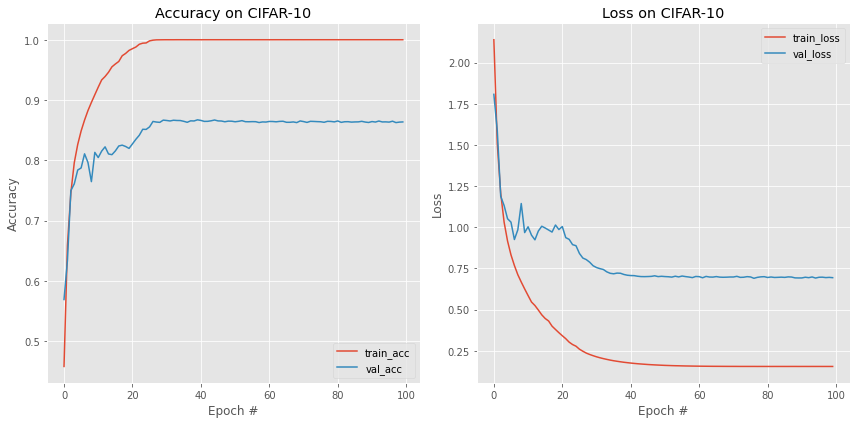

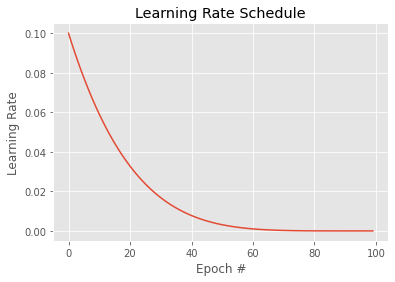

In [14]:
# evaluate network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=128)
print(
    classification_report(
        test_y.argmax(axis=1),
        predictions.argmax(axis=1),
        target_names=label_names
    )
)


# plot learning curves
N = np.arange(0, args["epochs"])
plt.style.use("ggplot")
# fig = plt.figure(figsize=(12,6))

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# plt.subplot(1, 2, 1)
ax[0].plot(N, H.history["accuracy"], label="train_acc")
ax[0].plot(N, H.history["val_accuracy"], label="val_acc")
ax[0].set_title("Accuracy on CIFAR-10")
ax[0].set_xlabel("Epoch #")
ax[0].set_ylabel("Accuracy")
ax[0].grid(True)
ax[0].legend(loc="lower right")

# ax[1].subplot(1, 2, 2)
ax[1].plot(N, H.history["loss"], label="train_loss")
ax[1].plot(N, H.history["val_loss"], label="val_loss")
ax[1].set_title("Loss on CIFAR-10")
ax[1].set_xlabel("Epoch #")
ax[1].set_ylabel("Loss")
ax[1].grid(True)
ax[1].legend(loc="upper right")

fig.tight_layout()
plt.savefig(args["train_plot"])

if schedule is not None:
    schedule.plot(N)
    plt.savefig(args["lr_plot"])